In [202]:
import re
import warnings
warnings.filterwarnings("ignore")


import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import matplotlib.transforms as transforms

import seaborn as sns

import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA #мультфакторная анова
from statsmodels.formula.api import ols #линейные модели 

from scipy.stats import f_oneway as ANOVA

import scipy


![alt text](map.jpg "Схема GPS")

# Агрохимия 

In [368]:
agrochemistry_total = pd.read_csv('полевые данные общая/ready_data/агрохимия.csv')
agrochemistry_total["Год"] = agrochemistry_total["Год"].astype(str)
agrochemistry_total["GPS №"] = agrochemistry_total["GPS №"].astype(str)
agrochemistry_total.columns

Index(['Год', 'GPS №', 'Тип обработки', 'Глубина', 'повторность',
       'рН солевой вытяжки, ед. рН', 'рН водной вытяжки, ед. рН',
       'Фосфор (подвижная форма), мг/кг', 'Калий (подвижная форма), млн-1',
       'Общий азот, %', 'Общий углерод, %',
       'М.д. содержания  гипса (по Хитрову), %',
       'Массовая доля иона хлорида, ммоль/100 г',
       'Массовая доля иона сульфата, ммоль/100 г',
       'Массовая доля магния (водорастворимая форма), ммоль/100 г почвы',
       'Массовая доля кальция (водорастворимая форма), ммоль/100 г почвы',
       'Массовая доля натрия (водорастворимая форма), мг•экв на 100 г почвы',
       'Массовая доля калия (водорастворимая форма), мг•экв на 100 г почвы',
       'Сумма поглощенных оснований по Каппену, ммоль/100 г',
       'Массовая доля плотного остатка водной вытяжки, %',
       'Карбонат и бикарбонат-ионы, ммоль/100 г',
       'Массовая доля общего содержания карбонатов (по Козловскому), % (CO2)',
       'Массовая доля общего содержания карб

### Агрохимические показатели по пахатному горизонту

In [369]:
agrochem_columns = ['Год', 'GPS №', 'Тип обработки', 'Глубина', 'повторность',
       'рН солевой вытяжки, ед. рН', 'рН водной вытяжки, ед. рН',
       'Фосфор (подвижная форма), мг/кг', 'Калий (подвижная форма), млн-1',
       'Общий азот, %', 'Органический углерод, %']
agrochemistry_main = agrochemistry_total[agrochemistry_total['Глубина'].isin(['0-10',"10-20","20-30"])][agrochem_columns]
agrochemistry_main.drop('повторность', axis = 1, inplace= True)
agrochemistry_main.dropna(axis = 0, inplace= True)


In [4]:

def aov_for_nominal(df, agrochem_property):
    """
    input - dataframe by agrochemical_proprerty
    output - resul of MANOVA
    """
    dispers = df.copy()
    agrochem_property_ = re.sub(r'[\(),.%№ /-]', '' , agrochem_property)
    dispers.columns = dispers.columns.str.replace(r'[\(),.%№ /-]', '', )
    reg = ols('{} ~ Год + Глубина  +  Типобработки + GPS'.format(agrochem_property_) ,  data=dispers).fit()
    aov = sm.stats.anova_lm(reg)
    aov = aov[["PR(>F)"]]
    aov.columns = ['p-value']
    aov = aov.iloc[:4,:]
    aov['p-value'] = round(aov['p-value'] , 3)
    return aov

def anova(df, varible, agrochem_property):
    stat_test_df = pd.DataFrame()
    for ind,depth in enumerate(df["Глубина"].unique()): 
        df_by_depth = df[df["Глубина"] == depth]
        sample_list = []
        for value  in df[varible].unique():
            sample = df_by_depth[agrochem_property][df[varible] == value].values
            sample_list.append(sample) 
        
        p_val = ANOVA(*sample_list)[1]
        local_df = pd.DataFrame({"глубина":depth, 'p-value' : p_val}, index = [ind])
        stat_test_df = stat_test_df.append(local_df)
    stat_test_df["p-value"] = round(stat_test_df["p-value"],3)
    return(stat_test_df)
    
def ploting( df, hue,  agrochem_property , aov ,stat_test_df, to_lable = "по обработкам" ):
    fig = plt.figure(figsize=(7,7))
    ax1 = plt.subplot2grid((3,2), (0, 0), colspan=2, rowspan = 2)
    ax2 = plt.subplot2grid((3,2), (2, 0))
    ax3 = plt.subplot2grid((3,2), (2, 1))
    if len(df[hue].unique()) == 2:
        pal =  "prism_r"
    else:
        pal =  "tab10"
    sns.pointplot(data = df,
        x = "Глубина",
        y = agrochem_property,
        hue = hue,
        palette = pal,
        scale = 1.2,
        ci = 95,
        dodge= 0.5,
        join = False,
        capsize = .05,
        ax = ax1)
    ax1.set_title('Сравнение по {}'.format(to_lable))

    ax2.axis('off')
    ax2.axis('tight')
    ax2.table(aov.values,rowLabels=aov.index , colLabels = aov.columns ,loc='center')
    ax2.set_title('Дисперсионный анализ \nпо {} (MANOVA)'.format(to_lable),  y=0.75 , x = 0.5)

    ax3.axis('off')
    ax3.axis('tight')
    ax3.table(stat_test_df.values, colLabels = stat_test_df.columns ,loc='center')
    ax3.set_title('Сравнение выборок \nпо {} (ANOVA)'.format(to_lable),  y=0.75 , x = 0.5)
    plt.show(block=True)
    return fig 

def data_processing(df, type_ , agrochem_property , to_lable = "1" ):
    stats_type = df.groupby([type_,'Глубина']).agg({ np.mean,  np.std, scipy.stats.variation})
    features = ['Год', 'GPS №', 'Тип обработки', 'Глубина']
    features.append(agrochem_property) #добавление фичи
    df = df[features]
    stats = df.groupby([type_,'Глубина']).agg({ np.mean,  np.std, scipy.stats.variation})

    aov = aov_for_nominal(df, agrochem_property)
    stat_test_df = anova(df, type_, agrochem_property)
    fig = ploting(df, type_, agrochem_property, aov,stat_test_df,to_lable  )

    return(stats , aov, stat_test_df,fig )


#### отобрали данные

описательные статистики

<ipython-input-4-681cbcfe293d>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  dispers.columns = dispers.columns.str.replace(r'[\(),.%№ /-]', '', )


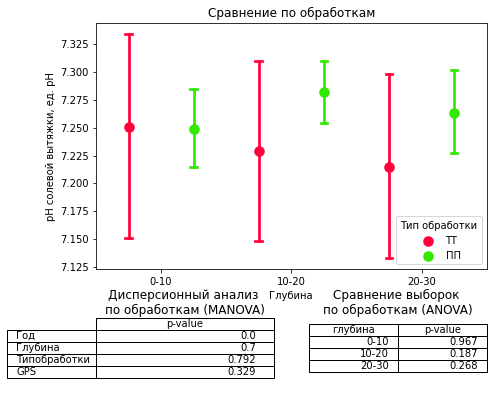

In [5]:
_,_,_ ,fig = data_processing(df = agrochemistry_main, type_ = 'Тип обработки', agrochem_property = 'рН солевой вытяжки, ед. рН', to_lable = "обработкам")

<ipython-input-4-681cbcfe293d>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  dispers.columns = dispers.columns.str.replace(r'[\(),.%№ /-]', '', )


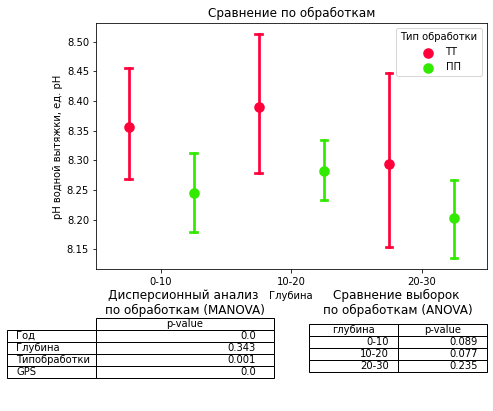

In [6]:
_,_,_ ,fig = data_processing(df = agrochemistry_main, type_ = 'Тип обработки', agrochem_property = 'рН водной вытяжки, ед. рН', to_lable = "обработкам")

<ipython-input-4-681cbcfe293d>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  dispers.columns = dispers.columns.str.replace(r'[\(),.%№ /-]', '', )


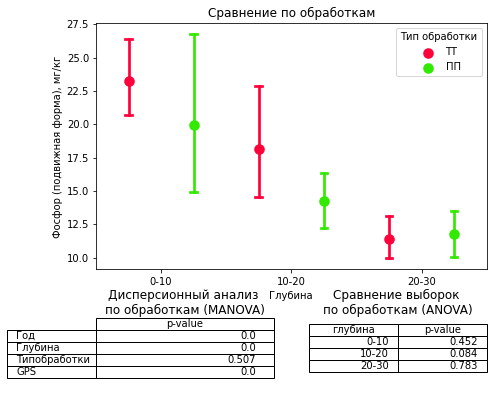

In [7]:
_,_,_ ,fig = data_processing(df = agrochemistry_main, type_ = 'Тип обработки', agrochem_property = 'Фосфор (подвижная форма), мг/кг', to_lable = "обработкам")

<ipython-input-4-681cbcfe293d>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  dispers.columns = dispers.columns.str.replace(r'[\(),.%№ /-]', '', )


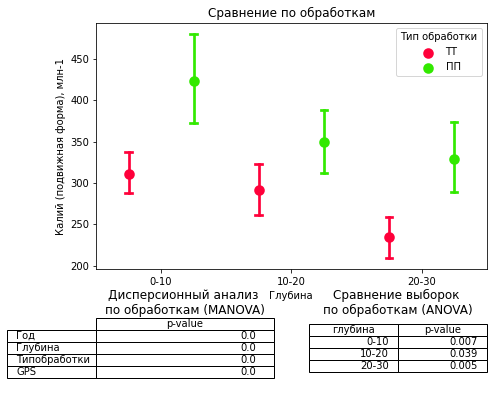

In [8]:
_,_,_ ,fig = data_processing(df = agrochemistry_main, type_ = 'Тип обработки', agrochem_property = 'Калий (подвижная форма), млн-1', to_lable = "обработкам")

<ipython-input-4-681cbcfe293d>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  dispers.columns = dispers.columns.str.replace(r'[\(),.%№ /-]', '', )


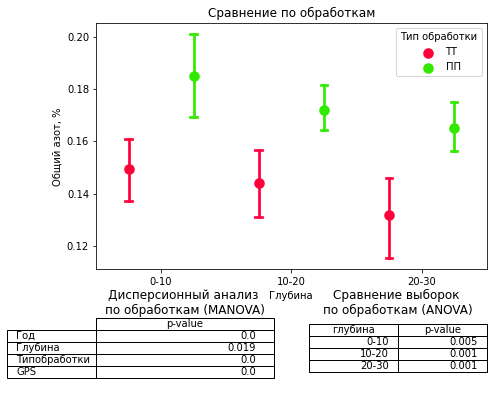

In [9]:
_,_,_ ,fig = data_processing(df = agrochemistry_main, type_ = 'Тип обработки', agrochem_property = 'Общий азот, %', to_lable = "обработкам")

<ipython-input-4-681cbcfe293d>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  dispers.columns = dispers.columns.str.replace(r'[\(),.%№ /-]', '', )


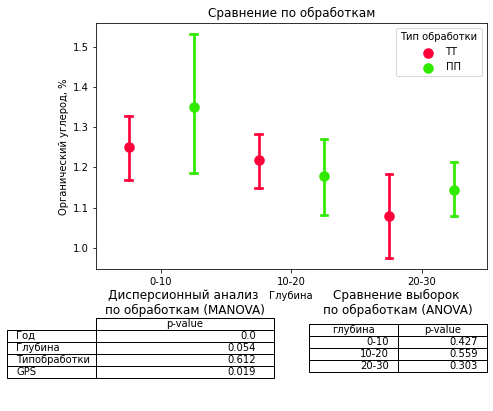

In [10]:
_,_,_ ,fig = data_processing(df = agrochemistry_main, type_ = 'Тип обработки', agrochem_property = 'Органический углерод, %', to_lable = "обработкам")

In [11]:
pp_points = ["525","526","527","528","586"]
by_points = agrochemistry_main[agrochemistry_main["GPS №"].isin(pp_points)]

<ipython-input-4-681cbcfe293d>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  dispers.columns = dispers.columns.str.replace(r'[\(),.%№ /-]', '', )


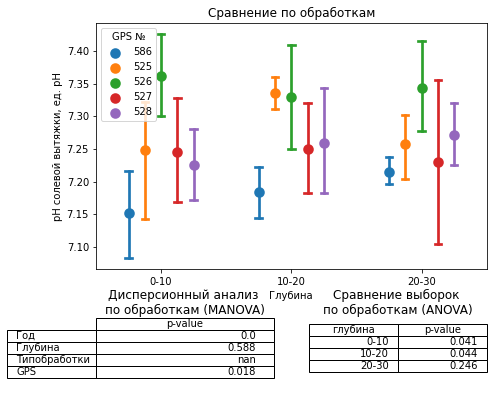

In [12]:
_,_,_ ,fig = data_processing(df = by_points, type_ = "GPS №", agrochem_property = 'рН солевой вытяжки, ед. рН', to_lable = "обработкам")

<ipython-input-4-681cbcfe293d>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  dispers.columns = dispers.columns.str.replace(r'[\(),.%№ /-]', '', )


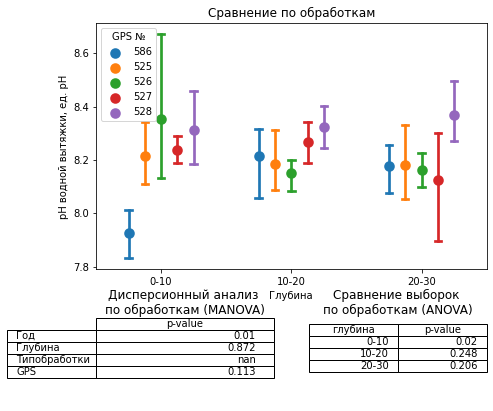

In [13]:
_,_,_ ,fig = data_processing(df = by_points, type_ = "GPS №", agrochem_property = 'рН водной вытяжки, ед. рН', to_lable = "обработкам")

<ipython-input-4-681cbcfe293d>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  dispers.columns = dispers.columns.str.replace(r'[\(),.%№ /-]', '', )


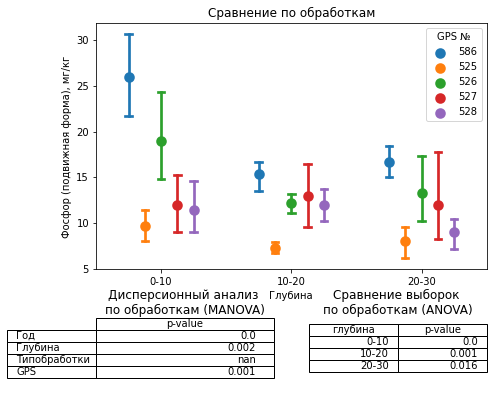

In [14]:
_,_,_ ,fig = data_processing(df = by_points, type_ = "GPS №", agrochem_property = 'Фосфор (подвижная форма), мг/кг', to_lable = "обработкам")

<ipython-input-4-681cbcfe293d>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  dispers.columns = dispers.columns.str.replace(r'[\(),.%№ /-]', '', )


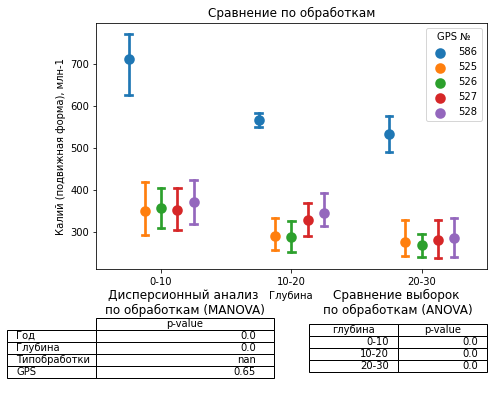

In [15]:
_,_,_ ,fig = data_processing(df = by_points, type_ = "GPS №", agrochem_property = 'Калий (подвижная форма), млн-1', to_lable = "обработкам")

<ipython-input-4-681cbcfe293d>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  dispers.columns = dispers.columns.str.replace(r'[\(),.%№ /-]', '', )


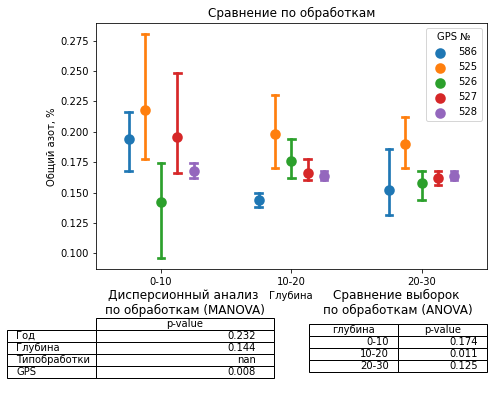

In [16]:
_,_,_ ,fig = data_processing(df = by_points, type_ = "GPS №", agrochem_property = 'Общий азот, %', to_lable = "обработкам")

<ipython-input-4-681cbcfe293d>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  dispers.columns = dispers.columns.str.replace(r'[\(),.%№ /-]', '', )


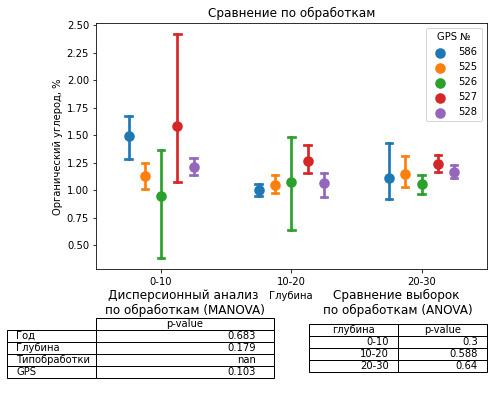

In [17]:
_,_,_ ,fig = data_processing(df = by_points, type_ = "GPS №", agrochem_property = 'Органический углерод, %', to_lable = "обработкам")

получилось все сделать тут надо допилить фоном обеспеченность 

Почвенные профили - код готов следующее это посмотреть в учебнике на работе какие профили надо использовать 

In [360]:
agrochem_features = [  'Фосфор (подвижная форма), мг/кг',
    'Калий (подвижная форма), млн-1',
    'Общий азот, %''рН солевой вытяжки, ед. рН',
    'рН водной вытяжки, ед. рН', 
    'М.д. содержания  гипса (по Хитрову), %',
    'Массовая доля общего содержания карбонатов (по Козловскому), % (CO2)',
    'Органический углерод, %']

horizonts = ['A',"B" , "C"]
depth = [[0,35],[35,100], [100 ,175]]
colors = ["#6E2C00","#BF7F50", "#FFDF29"]
def profile_plot(sample, horizonts,depth, colors,plotname ):
    agrochem_features =[
    'Сумма поглощенных оснований по Каппену, ммоль/100 г',  
    'Фосфор (подвижная форма), мг/кг',
    'Калий (подвижная форма), млн-1',
    'Общий азот, %',
    'рН солевой вытяжки, ед. рН',
    'рН водной вытяжки, ед. рН', 
    'М.д. содержания  гипса (по Хитрову), %',
    'Массовая доля общего содержания карбонатов (по Козловскому), % (CO2)',
    'Органический углерод, %'
    ]

    agrochem_features_labs = [
        "СПО, ммоль/100 г",
        'Фосфор, мг/кг',
        'Калий, мг/кг', 
        'Общий азот, %',
        'рН сол.',
        'рН вод.',
        "Гипс, %",
        "Карботнаты, %",
        "Орг. Углерод, %" ]
    limits = [
        (0,12),
        (0,40),
        (0,700),
        (0, 0.5),
        (6,8.5),
        (6,9.5),
        (0,6), 
        (0,5),
        (0,2)

    ]

    plot_num = len(agrochem_features)
    sizes = [1] * plot_num
    sizes.append( 0.5)
    hr = {'height_ratios': sizes}
    fig, ax  = plt.subplots(plot_num + 1,1, figsize = (10,plot_num * 2), gridspec_kw=hr )

    sns.lineplot(data =sample, y ='Органический углерод, %' , x = "depth" ,alpha = 0,ci=None, ax = ax[-1])
    ax[-1].set( ylabel ='Горизонт', yticks =[]  )
    ax[-1].set_xticklabels(ax[-1].get_xticks(), rotation = 90)
    ax[-1].set_xlabel('глубина', rotation = 180)
    ax[-1].set_title('№ скважины {}'.format(plotname), fontsize = 16, rotation = 90, x = -0.1, y = 2)

    for hor in range(len(horizonts)):
        ax[-1].fill_between(x =depth[hor],y1 = 2, color=colors[hor], alpha=0.7)
        text_position = (depth[hor][1] - depth[hor][0])/2 + depth[hor][0]
        ax[-1].text(x = text_position , y = 0.6, s = horizonts[hor],size = 16,weight='bold' , rotation = 90)


    for num, prop in enumerate(agrochem_features):
        sns.lineplot(data =sample, y =prop , x = "depth" ,color = 'black', ci=None, ax = ax[num])
        ax[num].set(xticks=[], xlabel=None, ylabel =agrochem_features_labs[num] , ylim=limits[num])
        ax[num].set_yticklabels(ax[num].get_yticks(), rotation = 90)
        for line in depth:
            ax[num].axvline(line[1],color =  "black", alpha = 0.5, linestyle = "--")







In [374]:
sample = agrochemistry_total[agrochemistry_total["GPS №"] == '527']
sample['depth'] = sample["Глубина"].str.split('-', expand=True)[0]
sample['depth'] = sample['depth'].astype(int)
sample = sample.round(2)
sample = sample.dropna(axis=1)
sample


,Год,GPS №,Тип обработки,Глубина,повторность,"рН солевой вытяжки, ед. рН","рН водной вытяжки, ед. рН","Фосфор (подвижная форма), мг/кг","Калий (подвижная форма), млн-1",depth
136,2020,527,ПП,0-10,[0],7.40,8.16,17.65,444.47,0
137,2020,527,ПП,10-20,[0],7.26,8.16,15.68,363.70,10
138,2020,527,ПП,20-30,[0],7.42,8.06,23.07,377.67,20
139,2020,527,ПП,30-40,[0],7.09,8.14,10.26,239.09,30
140,2020,527,ПП,40-50,[0],7.09,8.24,6.81,170.06,40
141,2020,527,ПП,50-60,[0],7.10,8.40,4.84,162.16,50
142,2020,527,ПП,60-70,[0],7.33,8.45,4.84,139.99,60
143,2020,527,ПП,70-80,[0],7.42,8.50,4.84,140.02,70
144,2020,527,ПП,80-90,[0],7.49,8.47,3.86,139.76,80
145,2020,527,ПП,90-100,[0],7.62,8.37,1.89,127.49,90


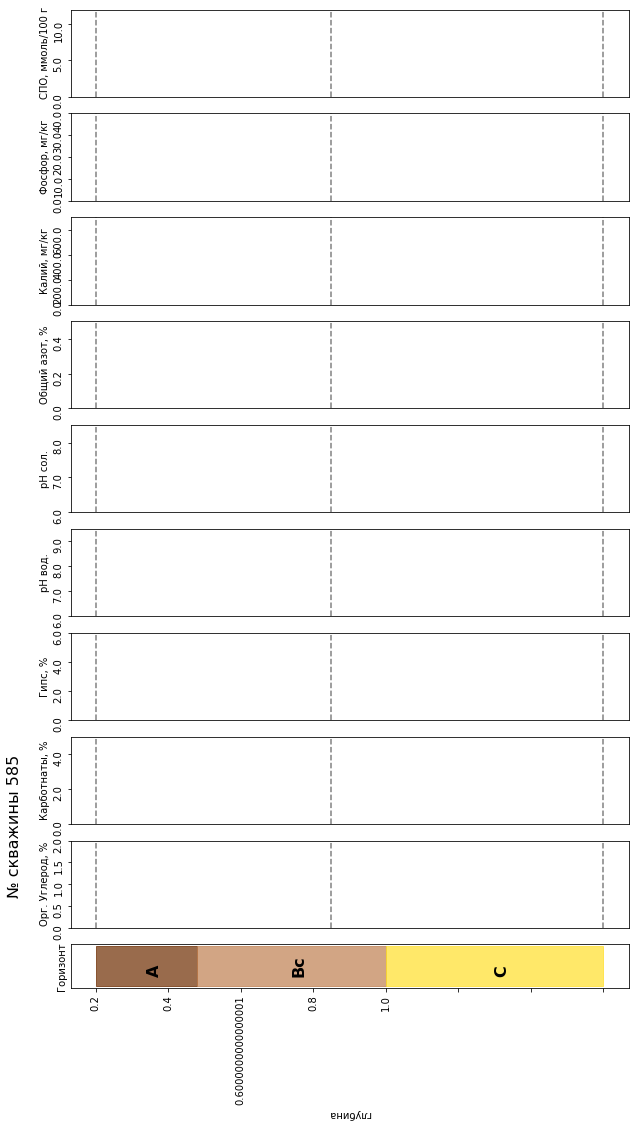

In [364]:

horizonts = ['A',"Bc" , "C"]
depth = [[0,35],[35,100], [100 ,175]]
colors = ["#6E2C00","#BF7F50", "#FFDF29"]

profile_plot(sample, horizonts,depth, colors,'585' )

In [354]:
def salt_profile(sample):    
    kations = ['Массовая доля кальция (водорастворимая форма), ммоль/100 г почвы',
        'Массовая доля магния (водорастворимая форма), ммоль/100 г почвы',
        'Массовая доля натрия (водорастворимая форма), мг•экв на 100 г почвы',
        'Массовая доля калия (водорастворимая форма), мг•экв на 100 г почвы'
    ]
    anions = ['Карбонат и бикарбонат-ионы, ммоль/100 г', 
        'Массовая доля иона хлорида, ммоль/100 г',
        'Массовая доля иона сульфата, ммоль/100 г'
    ]
    sample[anions] = sample[anions] * -1 


    anions.extend(kations)
    salts = anions.copy()
    anions.extend(["Массовая доля плотного остатка водной вытяжки, %", "depth"])
    salt_sample = sample[anions]

    colors = ['#FF0000', "#FFF300", "#13FF00", "#00FFFB","#0000FF","#C500FF", "#FF0068" ]
    labs = ["CO\u2083\u00B2\u207B и HCO\u2083\u207B" , 
    "Cl\u207B",
    "SO\u2084\u00B2\u207B",
    "Ca\u00B2\u207A",
    "Mg\u00B2\u207A",
    "Na\u207A",
    "K\u207A"]
    legend_list = []
    for i in range(len(labs)):
        legend_list.append(mpatches.Patch(color=colors[i], label= labs[i],alpha=0.5))

    hr = {'height_ratios': [ 2,4]}
    fig, ax  = plt.subplots(2,1, figsize = (10,6), gridspec_kw=hr )

    sns.lineplot(data =salt_sample, y ="Массовая доля плотного остатка водной вытяжки, %" , x = "depth", color = 'black' ,ci=None, ax = ax[0])
    ax[0].invert_xaxis()
    ax[0].set(xticks=[], xlabel=None, ylabel ='Плотн.ост, %' )
    ax[0].set(ylim=(0, 2), label = '')
    ax[0].set_yticklabels(ax[0].get_yticks(), rotation = 90)


    for num, sal in enumerate(salts):
        sns.lineplot(data =salt_sample, y =sal , x = "depth" ,color = colors[num], ci=None, ax = ax[1])
        ax[1].fill_between(x =salt_sample["depth"],y1 = 0, y2 = salt_sample[sal], color= colors[num], alpha=0.5)

    ax[1].set(ylim=(-4, 4), ylabel ='Концентрация растворимых солей\nммоль/100 г')
    ax[1].axhline(0,color =  "black")
    ax[1].set_xticklabels(ax[-1].get_xticks(), rotation = 90)
    ax[1].set_xlabel('глубина', rotation = 180)
    ax[1].set_yticklabels(ax[1].get_yticks(), rotation = 90)


    plt.legend(handles=legend_list, title='Растворимые соли', loc='lower left', mode = 'expand',ncol = 3, bbox_to_anchor=(1, 0.5, 0.5, 0.5))

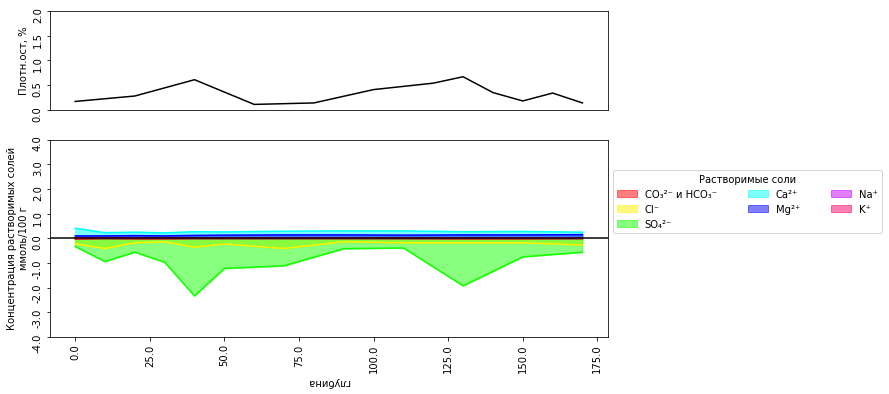

In [355]:
salt_profile(sample)

['Карбонат и бикарбонат-ионы, ммоль/100 г',
 'Массовая доля иона хлорида, ммоль/100 г',
 'Массовая доля иона сульфата, ммоль/100 г',
 'Массовая доля кальция (водорастворимая форма), ммоль/100 г почвы',
 'Массовая доля магния (водорастворимая форма), ммоль/100 г почвы',
 'Массовая доля натрия (водорастворимая форма), мг•экв на 100 г почвы',
 'Массовая доля калия (водорастворимая форма), мг•экв на 100 г почвы']

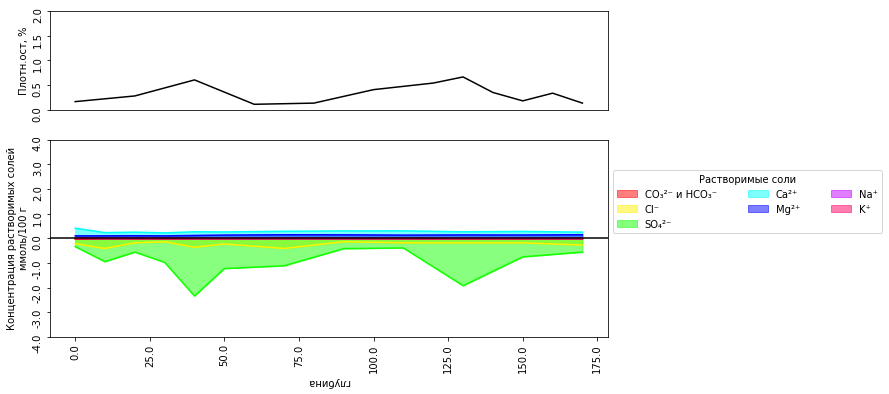

In [222]:
hr = {'height_ratios': [ 2,4]}
fig, ax  = plt.subplots(2,1, figsize = (10,6), gridspec_kw=hr )

sns.lineplot(data =salt_sample, y ="Массовая доля плотного остатка водной вытяжки, %" , x = "depth", color = 'black' ,ci=None, ax = ax[0])
ax[0].invert_xaxis()
ax[0].set(xticks=[], xlabel=None, ylabel ='Плотн.ост, %' )
ax[0].set(ylim=(0, 2), label = '')
ax[0].set_yticklabels(ax[0].get_yticks(), rotation = 90)


for num, sal in enumerate(salts):
    sns.lineplot(data =salt_sample, y =sal , x = "depth" ,color = colors[num], ci=None, ax = ax[1])
    ax[1].fill_between(x =salt_sample["depth"],y1 = 0, y2 = salt_sample[sal], color= colors[num], alpha=0.5)

ax[1].set(ylim=(-4, 4), ylabel ='Концентрация растворимых солей\nммоль/100 г')
ax[1].axhline(0,color =  "black")
ax[1].set_xticklabels(ax[-1].get_xticks(), rotation = 90)
ax[1].set_xlabel('глубина', rotation = 180)
ax[1].set_yticklabels(ax[1].get_yticks(), rotation = 90)


plt.legend(handles=legend_list, title='Растворимые соли', loc='lower left', mode = 'expand',ncol = 3, bbox_to_anchor=(1, 0.5, 0.5, 0.5))

Распределение растворимых солей по профилю 

In [21]:
def salts_profile(salts_df,plotname):
        salts_type = salts.columns[1:-1]
        salts_labs = [
                'М.д. хлор.\nммоль/100 г',
                'М.д. сульф.\nммоль/100 г',
                'М.д. Mg\nммоль/100 г',
                'М.д. Ca\nммоль/100 г',
                'М.д. Na\nмг•экв/100 г',
                'М.д. K\nмг•экв/100 г']

        fig, ax  = plt.subplots( len(salts_labs) + 1,1, figsize = (10,14))





        for num, prop in enumerate(salts_type):
                sns.lineplot(data =salts_df, y =prop , x = "depth" ,color = 'black', ci=None, ax = ax[num])
                ticks = ax[num].get_xticks()
                ax[num].set(xticks=[], xlabel=None, ylabel =salts_labs[num] )
                ax[num].set_yticklabels(ax[num].get_yticks(), rotation = 90)

        sns.lineplot(data =salts_df, y ='Массовая доля плотного остатка водной вытяжки, %' , x = "depth" ,color = "black",ci=None, ax = ax[-1])
        ax[-1].set( ylabel ='М.д. плот.ост.\n%'  )

        ax[-1].set_xticklabels(ticks, rotation = 90)
        ax[-1].set_xlabel('глубина', rotation = 180)


        ax[-1].set_title('№ скважины {}'.format(plotname), fontsize = 16, rotation = 90, x = -0.1, y = 2)


<ipython-input-71-c23839cf1d92>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[num].set_yticklabels(ax[num].get_yticks(), rotation = 90)
<ipython-input-71-c23839cf1d92>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[num].set_yticklabels(ax[num].get_yticks(), rotation = 90)
<ipython-input-71-c23839cf1d92>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[num].set_yticklabels(ax[num].get_yticks(), rotation = 90)
<ipython-input-71-c23839cf1d92>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[num].set_yticklabels(ax[num].get_yticks(), rotation = 90)
<ipython-input-71-c23839cf1d92>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[num].set_yticklabels(ax[num].get_yticks(), rotation = 90)
<ipython-input-71-c23839cf1d92>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[num].set_ytick

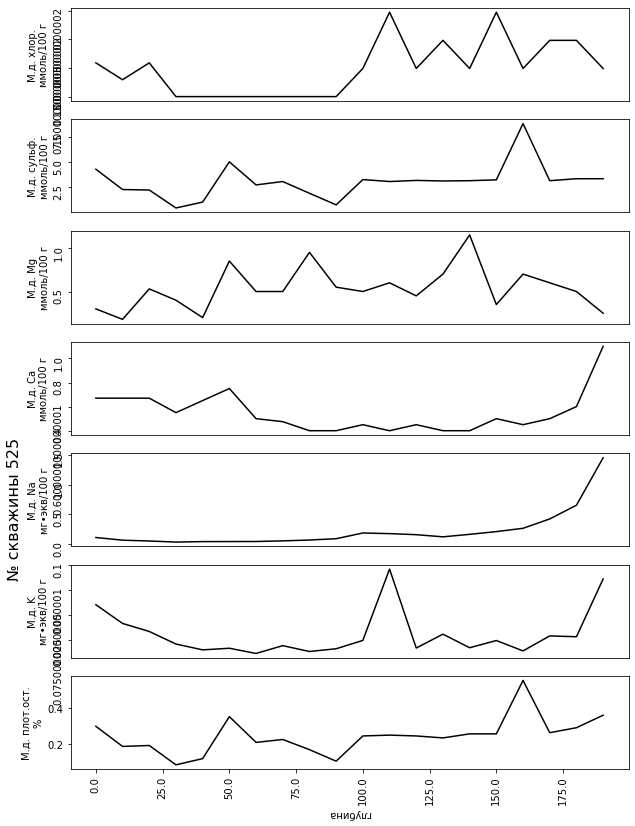

In [72]:
salts_profile(sample , '525')